In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
data_folder = Path('./data')
classes = list(data_folder.iterdir())
classes

[PosixPath('data/running'),
 PosixPath('data/stairs'),
 PosixPath('data/walking'),
 PosixPath('data/idle')]

In [3]:
dfs = []
def flatten_sensor_frame(df): return df.values.flatten()
data_list = []
for class_folder in classes:
    for file in class_folder.iterdir():
        df = pd.read_csv(file)

        frame = flatten_sensor_frame(df)
        record = list((frame)) + [str(class_folder)]
        data_list.append(record)
        
        df['label'] = class_folder
        dfs.append(df)

    
cols = [str(i) for i in range(90)] + ['label']
full_df = pd.DataFrame(data=data_list, columns=cols)

In [4]:
full_df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,label
0,2.667141,-7.838616,-9.548077,4.017470,8.705317,-2.226607,22.357056,20.887016,-2.820370,17.922995,...,-0.885855,11.310209,-8.939949,13.771448,9.825804,1.470040,-2.044648,6.689400,10.807426,data/running
1,10.745177,23.415293,1.144428,3.744532,-9.035717,-2.892196,0.766145,21.092916,-0.928950,23.956383,...,1.532289,15.782578,1.699883,14.168885,32.245110,3.390190,3.983952,-1.867477,-1.407790,data/running
2,22.031445,18.406622,1.537078,3.600880,12.368446,2.217031,-0.354342,-13.206416,-7.254431,8.245631,...,4.151546,24.502260,-1.139640,-0.493206,-14.542381,-2.164358,2.442086,9.677363,-3.016694,data/running
3,10.371682,-1.608903,-2.801216,25.718515,16.247053,-6.488286,-3.600879,6.684612,-2.375048,10.534488,...,17.056293,37.330395,5.621586,2.695871,11.626244,-1.082179,8.681376,12.124237,-4.946420,data/running
4,3.624822,9.059659,4.390966,33.073500,33.202790,4.802769,3.792416,3.596091,-2.681506,-1.872266,...,1.187524,13.072341,-1.953669,1.441310,-14.585477,3.610456,6.028600,17.889475,-0.732626,data/running


In [5]:
df = full_df[(full_df.label == 'data/walking') | (full_df.label == 'data/stairs')].copy().reset_index(drop=True)

In [6]:
df.shape

(2015, 91)

In [7]:
df['is_stairs'] = df['label'] == 'data/stairs'

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
feature_cols = [str(i) for i in range(90)]

In [10]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [11]:
X = df[[str(i) for i in range(90)] ]
y = df['is_stairs']

In [12]:
y.value_counts()

False    1850
True      165
Name: is_stairs, dtype: int64

In [13]:
train_ix, valid_ix = list(kfold.split(X, y))[4]
X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]

In [14]:
y_train.value_counts()

False    1480
True      132
Name: is_stairs, dtype: int64

In [15]:
y.value_counts()

False    1850
True      165
Name: is_stairs, dtype: int64

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [17]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
f1_score(y_valid, y_pred)

[[358  12]
 [ 21  12]]


0.4210526315789474

In [18]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
f1_score(y_valid, y_pred)

[[314  56]
 [ 12  21]]


0.3818181818181818

In [19]:
from sklearn import svm

In [20]:
cls = svm.SVC()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
f1_score(y_valid, y_pred)

[[369   1]
 [ 18  15]]


0.6122448979591837

In [21]:
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

F1 score mean: 0.64, std: 0.07


In [22]:
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = svm.SVC(class_weight='balanced')
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

F1 score mean: 0.59, std: 0.06


In [23]:
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = svm.SVC(kernel='poly', degree=12)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

F1 score mean: 0.25, std: 0.05


# Feature engineering

In [24]:
class_labels = [ 'data/walking', 'data/stairs', 'data/idle', 'data/running']

# Try with more features

In [ ]:
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = svm.SVC(kernel='poly')
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

In [ ]:
def evaluate_SVM_poly():
    f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = svm.SVC(kernel='poly')
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

In [41]:
from sklearn.linear_model import LogisticRegressionCV

In [54]:
# class_weight = {True: 40, False: 1}
cv_logreg = LogisticRegressionCV(cv=kfold, max_iter=100_000)

In [55]:
cv_logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100000, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [56]:
y_pred = cv_logreg.predict(X_valid)
confusion_matrix(y_valid, y_pred)

array([[368,   2],
       [ 27,   6]])

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_valid)

In [59]:
confusion_matrix(y_valid, y_pred)

array([[341,  29],
       [  6,  27]])

In [70]:
n_neighbors = np.arange(1, 150)

k2score = {}
for n_neighbors in n_neighbors:
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_valid)
    score = f1_score(y_valid, y_pred)
    print(f'k = {n_neighbors}, f1_score = {round(score, 2)}')
    k2score[n_neighbors] = score

k = 1, f1_score = 0.6
k = 2, f1_score = 0.54
k = 3, f1_score = 0.57
k = 4, f1_score = 0.68
k = 5, f1_score = 0.61
k = 6, f1_score = 0.59
k = 7, f1_score = 0.57
k = 8, f1_score = 0.61
k = 9, f1_score = 0.63
k = 10, f1_score = 0.61
k = 11, f1_score = 0.63
k = 12, f1_score = 0.62
k = 13, f1_score = 0.62
k = 14, f1_score = 0.65
k = 15, f1_score = 0.63
k = 16, f1_score = 0.64
k = 17, f1_score = 0.61
k = 18, f1_score = 0.62
k = 19, f1_score = 0.58
k = 20, f1_score = 0.61
k = 21, f1_score = 0.62
k = 22, f1_score = 0.63
k = 23, f1_score = 0.64
k = 24, f1_score = 0.64
k = 25, f1_score = 0.63
k = 26, f1_score = 0.65
k = 27, f1_score = 0.6
k = 28, f1_score = 0.62
k = 29, f1_score = 0.6
k = 30, f1_score = 0.61
k = 31, f1_score = 0.6
k = 32, f1_score = 0.62
k = 33, f1_score = 0.62
k = 34, f1_score = 0.63
k = 35, f1_score = 0.61
k = 36, f1_score = 0.6
k = 37, f1_score = 0.62
k = 38, f1_score = 0.61
k = 39, f1_score = 0.62
k = 40, f1_score = 0.63
k = 41, f1_score = 0.62
k = 42, f1_score = 0.63
k = 43

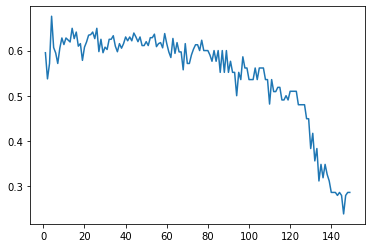

In [75]:
plt.plot(list(k2score.keys()), list(k2score.values()))

In [79]:
neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_valid)
confusion_matrix(y_pred, y_valid)

array([[367,  27],
       [  3,   6]])

array([[367,  27],
       [  3,   6]])

In [78]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
confusion_matrix(y_pred, y_valid)

array([[370,  32],
       [  0,   1]])

In [81]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
confusion_matrix(y_pred, y_valid)

array([[370,  32],
       [  0,   1]])

In [82]:
clf = RandomForestClassifier(class_weight=class_weight )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
confusion_matrix(y_pred, y_valid)

array([[370,  28],
       [  0,   5]])

In [83]:
clf = RandomForestClassifier(class_weight=class_weight, n_estimators=1000 )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
confusion_matrix(y_pred, y_valid)

array([[370,  31],
       [  0,   2]])

In [ ]:
clf = RandomForestClassifier(class_weight=class_weight, n_estimators=1000 )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
confusion_matrix(y_pred, y_valid)

In [61]:
import lightgbm

In [66]:
b00st = lightgbm.LGBMClassifier?

In [67]:
b00st = lightgbm.LGBMClassifier(class_weight=class_weight)

In [68]:
b00st.fit(X_train, y_train)
y_pred = b00st.predict(X_valid)
confusion_matrix(y_valid, y_pred)

array([[367,   3],
       [ 20,  13]])